# Assignment 3

This project compares three feedforward neural network training algorithms: Stochastic Gradient Descent (SGD), Scaled Conjugate Gradient (SCG), and LeapFrog. Using six datasets—three for classification and three for regression—the study evaluates convergence speed, stability, and predictive accuracy. Each network has a single hidden layer, with experiments across different hidden layer sizes and hyperparameters. Performance is measured using accuracy and F1-score for classification, and MSE, RMSE, and R² for regression, alongside training time and convergence behavior. The results highlight the strengths and weaknesses of each optimizer across problems of varying complexity.

## Setup

In [ ]:
! pip3 install -r requirements.txt

In [390]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.datasets import load_iris, fetch_california_housing, fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple, Optional, Callable
from ucimlrepo import fetch_ucirepo
import json
from datetime import datetime
from itertools import product
import time
import math
from collections import defaultdict

## Data and Pre Processing

In [235]:
def build_preprocessing_pipeline(X, classification=True):
    """
    Preprocessing pipeline for tabular datasets (Iris, Stroke, Wine, Sine).
    Skips MNIST and California housing (use custom pipelines for them).
    """
    # Identify feature types
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns

    # Numeric: impute missing values, then scale
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical: impute, then one-hot encode (drop='first' avoids dummy trap)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

In [ ]:
def preprocess_mnist(X, y, test_size=0.2, random_state=42):
    # Normalize pixel values to [0, 1]
    X_norm = X / 255.0

    # Flatten images (if not already flat)
    if len(X_norm.shape) > 2:
        X_flat = X_norm.reshape(X_norm.shape[0], -1)
    else:
        X_flat = X_norm

    # Encode target labels
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Stratified split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_flat, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    return X_train, X_test, y_train, y_test

In [ ]:
def preprocess_california_housing(X, y, skewed_features=['MedInc'], log_target=True, test_size=0.2, random_state=42):
    # Log-transform skewed features
    X_processed = X.copy()
    for col in skewed_features:
        X_processed[col] = np.log1p(X_processed[col])

    # Log-transform target if needed
    if log_target:
        y_processed = np.log1p(y)
    else:
        y_processed = y.copy()

    # Check for NaNs after transformation
    if X_processed.isnull().any().any():
        print("Warning: NaNs found in features after log transformation.")
    if pd.isnull(y_processed).any():
        print("Warning: NaNs found in target after log transformation.")

    # Build and fit pipeline
    preprocessor = build_preprocessing_pipeline(X_processed, classification=False)
    X_scaled = preprocessor.fit_transform(X_processed)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_processed, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, y_train, y_test

In [239]:
def preprocess_data(train, val, test, scale=True, impute=False, classification=True):
    """
    Fit preprocessing on train, apply to val/test.
    scale: whether to standardize numeric features
    impute: whether to impute missing values
    classification: whether the task is classification (affects pipeline)
    """
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test

    # Build and fit pipeline on training data
    preprocessor = build_preprocessing_pipeline(X_train, classification=classification)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    if classification:
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_val = le.transform(y_val)
        y_test = le.transform(y_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test

In [234]:
def split_train_val_test(X, y, test_size=0.15, val_fraction_of_total=0.15,
                         random_state=42, stratify=None):
    """
    Split dataset into train, validation, and test sets.
    """
    # First split: train_val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify
    )

    # Compute val_size relative to train_val
    val_size = val_fraction_of_total / (1 - test_size)

    # Second split: train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size,
        random_state=random_state, stratify=y_train_val if stratify is not None else None
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

### Classification

In [ ]:
# Iris Dataset
def load_iris_data():
    iris = sns.load_dataset("iris")
    print(iris.head())

    X_iris = iris.drop("species", axis=1)
    y_iris = iris["species"]
    print(X_iris.head())
    print(y_iris.head())
    return X_iris, y_iris

In [ ]:
# Stroke Prediction Dataset
def load_stroke_data():
    stroke_data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
    print(stroke_data.shape)
    X_stroke = stroke_data.drop("stroke", axis=1)
    y_stroke = stroke_data["stroke"]
    print(X_stroke.head())
    print(y_stroke.head())
    return X_stroke, y_stroke

In [ ]:
# MNIST Dataset
def load_mnist_subset(n_samples=10000, random_state=42):
    mnist = fetch_openml('mnist_784', version=1)
    X = pd.DataFrame(mnist.data)
    y = pd.Series(mnist.target, name="digit")
    # Sample 10k rows
    X_mnist = X.sample(n=n_samples, random_state=random_state)
    y_mnist = y.loc[X_mnist.index]
    print(X_mnist.shape)
    print(X_mnist.head())
    print(y_mnist.head())
    return X_mnist, y_mnist

### Function approx.

In [ ]:
# Synthetic Sine Wave Dataset
def generate_sine_wave_data(num_samples: int = 1000, noise_level: float = 0.1, random_state: int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    rng = np.random.default_rng(random_state)
    X = np.linspace(0, 2 * np.pi, num_samples)
    y = np.sin(X) + noise_level * rng.standard_normal(num_samples)
    X_sine = pd.DataFrame(X, columns=["x"])
    y_sine = pd.Series(y, name="y")
    return X_sine, y_sine

In [ ]:
# Wine quality dataset from UCI ML Repository
def load_wine_quality_data():
    wine_quality = fetch_ucirepo(id=186) 
    
    # data (as pandas dataframes) 
    X_wine = wine_quality.data.features 
    y_wine = wine_quality.data.targets 
    print(wine_quality.metadata)
    print(wine_quality.variables)
    print(X_wine.head())
    print(y_wine.head())
    print (X_wine.shape, y_wine.shape)
    return X_wine, y_wine

In [ ]:
# California Housing Dataset
def load_california_housing_data(n_samples=10000, random_state=42):
    california = fetch_california_housing()
    X = pd.DataFrame(california.data, columns=california.feature_names)
    y = pd.Series(california.target, name="MedHouseVal")
    # Sample 10k rows
    X_california = X.sample(n=n_samples, random_state=random_state)
    y_california = y.loc[X_california.index]
    print(X_california.shape)
    print(X_california.head())
    print(y_california.head())
    return X_california, y_california

## Model

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn=nn.ReLU):
        super(FeedforwardNN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.activation = activation_fn()
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

### Training Algorithms

In [353]:
def train_sgd(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.01, batch_size=32, classification=True, momentum=0.0):
    criterion = nn.CrossEntropyLoss() if classification else nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    train_losses = []
    test_losses = []

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    if classification:
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    else:
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        train_loss = running_loss / len(loader.dataset)
        train_losses.append(train_loss)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            loss = criterion(outputs, y_test_tensor)
            test_losses.append(loss.item())

    return train_losses, test_losses

In [ ]:
# # Example usage of SGD - function approximation
# X_sine, y_sine = generate_sine_wave_data()
# X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(X_sine, y_sine, classification=False)
# model = FeedforwardNN(input_dim=1, hidden_dim=16, output_dim=1)
# train_losses, test_losses = train_sgd(
#     model,
#     X_train_scaled,
#     np.array(y_train).reshape(-1, 1).astype(np.float32),
#     X_test_scaled,
#     np.array(y_test).reshape(-1, 1).astype(np.float32),
#     classification=False
# )
# print("Train Losses:", train_losses)
# print("Test Losses:", test_losses)

In [ ]:
# # Example usage of SGD - Classification
# X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(X_iris, y_iris, classification=True)
# model = FeedforwardNN(input_dim=4, hidden_dim=16, output_dim=3)
# train_losses, test_losses = train_sgd(model, X_train_scaled, y_train, X_test_scaled, y_test)
# print("Train Losses:", train_losses)
# print("Test Losses:", test_losses)

In [382]:
def train_scg(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    max_epochs: int = 1000,
    tolerance: float = 1e-6,
    sigma: float = 5e-5,
    lambda_init: float = 5e-7,
    verbose: bool = True,
    eval_freq: int = 10,
    grad_clip: float = 5.0,
    max_alpha: float = 1.0
) -> Tuple[List[float], List[float]]:
    device = next(model.parameters()).device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Task detection (robust)
    if y_train.dtype in (torch.long, torch.int64) and y_train.ndim == 1:
        criterion = nn.CrossEntropyLoss()
        task_type = 'classification'
    else:
        criterion = nn.MSELoss()
        task_type = 'regression'

    def get_weights():
        return torch.cat([p.view(-1) for p in model.parameters()])

    def set_weights(w):
        idx = 0
        for p in model.parameters():
            n = p.numel()
            p.data = w[idx:idx+n].view(p.shape)
            idx += n

    def loss_and_grad(w):
        set_weights(w)
        model.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        g = torch.cat([p.grad.view(-1) for p in model.parameters()])
        return loss.item(), g

    def eval_split():
        model.eval()
        with torch.no_grad():
            tr = criterion(model(X_train), y_train).item()
            te = criterion(model(X_test), y_test).item()
        model.train()
        return tr, te

    n_params = sum(p.numel() for p in model.parameters())
    w_k = get_weights()
    f_k, g_k = loss_and_grad(w_k)
    r_k = g_k.clone()
    r_k_prev = None
    p_k = -r_k.clone()
    lambda_k = lambda_init
    success = True
    k_iter = 0

    train_losses = []
    test_losses = []

    tr0, te0 = eval_split()
    train_losses.append(tr0); test_losses.append(te0)
    if verbose:
        print(f"Initial - Train {tr0:.6f} Test {te0:.6f}")

    for epoch in range(max_epochs):
        if success:
            denom = torch.dot(p_k, p_k)
            if denom.abs() < 1e-18:
                if verbose: print("Direction norm too small; stopping.")
                break
            sigma_k = sigma / torch.sqrt(denom)

        # Finite difference Hessian-vector approx
        w_temp = w_k + sigma_k * p_k
        _, g_temp = loss_and_grad(w_temp)
        s_k = (g_temp - g_k) / sigma_k

        delta_k = torch.dot(p_k, s_k)
        if delta_k <= 0:
            s_k = s_k + (lambda_k - delta_k) * p_k
            delta_k = lambda_k * torch.dot(p_k, p_k)
            lambda_k *= 2

        mu_k = torch.dot(p_k, r_k)
        alpha_k = -mu_k / (delta_k + 1e-12)

        if abs(alpha_k) > max_alpha:
            alpha_k = torch.clamp(alpha_k, -max_alpha, max_alpha)

        Delta_k = -(alpha_k * mu_k + 0.5 * alpha_k * alpha_k * delta_k)

        w_new = w_k + alpha_k * p_k
        f_new, g_new = loss_and_grad(w_new)

        # NaN / Inf guard
        if not torch.isfinite(torch.tensor(f_new)):
            if verbose: print(f"Non-finite loss at epoch {epoch}; aborting this run.")
            break

        if Delta_k <= 0:
            r_ratio = -float('inf')
        else:
            r_ratio = (f_k - f_new) / Delta_k

        if r_ratio > 0:
            success = True
            w_k = w_new
            f_k = f_new
            r_k_prev = r_k.clone()
            g_k = g_new
            r_k = g_k.clone()

            if grad_clip is not None:
                g_norm = torch.norm(r_k)
                if g_norm > grad_clip:
                    r_k.mul_(grad_clip / (g_norm + 1e-12))
                    g_k = r_k  # keep consistent

            if r_ratio > 0.75:
                lambda_k /= 2
            elif r_ratio < 0.25:
                lambda_k *= 2
        else:
            success = False
            lambda_k *= 2  # increase damping

        if success:
            if k_iter % n_params == 0 or r_k_prev is None:
                p_k = -r_k.clone()
            else:
                beta_k = torch.dot(r_k, r_k - r_k_prev) / (torch.dot(r_k_prev, r_k_prev) + 1e-12)
                p_k = -r_k + beta_k * p_k
            k_iter += 1

            grad_norm = torch.norm(r_k).item()
            if grad_norm < tolerance:
                if verbose: print(f"Converged at epoch {epoch} ||g||={grad_norm:.2e}")
                break

        if epoch % eval_freq == 0 or epoch == max_epochs - 1:
            tr, te = eval_split()
            train_losses.append(tr)
            test_losses.append(te)
            if verbose:
                print(f"Epoch {epoch:4d} f={tr:.6f} test={te:.6f} ||g||={torch.norm(r_k):.2e} r={r_ratio:.3f} λ={lambda_k:.2e} α={float(alpha_k):.3e}")

    if verbose and len(train_losses):
        print(f"Final - Train {train_losses[-1]:.6f} Test {test_losses[-1]:.6f}")
    return train_losses, test_losses

**NOTE:**

*For classification tasks, the output layer is linear and we use `CrossEntropyLoss`, which applies the required softmax internally. For regression tasks, the output layer is also linear, and we use `MSELoss`.*

In [ ]:
# # Example usage of SCG - classification
# model = FeedforwardNN(input_dim=4, hidden_dim=16, output_dim=3)
# X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(X, y, classification=True)

# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# train_losses, test_losses = train_scg(
#     model=model,
#     X_train=X_train_tensor,
#     y_train=y_train_tensor,
#     X_test=X_test_tensor,
#     y_test=y_test_tensor,
#     max_epochs=500,
#     tolerance=1e-5,
#     verbose=True,
#     eval_freq=1
# )
# print("Train Losses:", train_losses)
# print("Test Losses:", test_losses)

In [ ]:
# # Example usage of SCG - function approximation
# model = FeedforwardNN(input_dim=1, hidden_dim=16, output_dim=1)
# X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(X_sine, y_sine, classification=False)
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# train_losses, test_losses = train_scg(
#     model=model,
#     X_train=X_train_tensor,
#     y_train=y_train_tensor,
#     X_test=X_test_tensor,
#     y_test=y_test_tensor,
#     max_epochs=500,
#     tolerance=1e-5,
#     verbose=True,
#     eval_freq=1
# )
# print("Train Losses:", train_losses)
# print("Test Losses:", test_losses)

In [ ]:
def train_lfrog(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    loss_fn: Optional[Callable] = None,
    epochs: int = 1000,
    dt: float = 0.5,
    max_step: float = 1.0,
    convergence_tol: float = 1e-5,
    max_consecutive_decreases: int = 2,
    time_step_reduction_threshold: int = 3,
    time_step_increase_factor: float = 0.001,
    batch_size: Optional[int] = None,
    device: str = 'cpu',
    print_every: int = 100,
    early_stopping_patience: int = 50,
    min_improvement: float = 1e-6
) -> Tuple[List[float], List[float]]:
    """
    Train a neural network using Snyman's LeapFrog dynamic optimization algorithm.
    
    Args:
        model: PyTorch neural network model
        X_train, y_train: Training data and labels
        X_test, y_test: Test data and labels
        loss_fn: Loss function (default: MSE for regression, CrossEntropy for classification)
        epochs: Maximum number of iterations
        dt: Initial time step
        max_step: Maximum allowable step size (δ in the paper)
        convergence_tol: Convergence tolerance for gradient norm
        max_consecutive_decreases: j parameter - max consecutive velocity decreases before reset
        time_step_reduction_threshold: m parameter - consecutive steps before time step reduction
        time_step_increase_factor: δ₁ parameter for time step increase
        batch_size: Batch size (None for full batch)
        device: Device to run on
        print_every: Print progress every N steps
    
    Returns:
        Tuple of (train_losses, test_losses) lists
    """
    
    # Move model and data to device
    model = model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    # Auto-detect loss function if not provided
    if loss_fn is None:
        if len(y_train.shape) == 1 or y_train.shape[1] == 1:
            if torch.all((y_train == 0) | (y_train == 1)):
                loss_fn = nn.BCEWithLogitsLoss()
            else:
                loss_fn = nn.MSELoss()
        else:
            loss_fn = nn.CrossEntropyLoss()
    
    # Initialize tracking variables
    train_losses = []
    test_losses = []
    
    # Early stopping variables
    best_test_loss = float('inf')
    patience_counter = 0
    
    # Get initial parameters as flat vector
    params = []
    for p in model.parameters():
        params.append(p.view(-1))
    x_k = torch.cat(params)
    n_params = len(x_k)
    
    # Compute initial gradient and velocity
    def compute_loss_and_grad():
        model.zero_grad()
        if batch_size is None:
            outputs = model(X_train)
            loss = loss_fn(outputs, y_train)
        else:
            # Mini-batch gradient
            idx = torch.randperm(len(X_train))[:batch_size]
            outputs = model(X_train[idx])
            loss = loss_fn(outputs, y_train[idx])
        
        loss.backward()
        
        # Extract gradients as flat vector
        grads = []
        for p in model.parameters():
            if p.grad is not None:
                grads.append(p.grad.view(-1))
            else:
                grads.append(torch.zeros_like(p.view(-1)))
        grad = torch.cat(grads)
        
        return loss.item(), grad
    
    def update_model_params(x):
        """Update model parameters from flat parameter vector"""
        idx = 0
        for p in model.parameters():
            param_size = p.numel()
            p.data = x[idx:idx + param_size].view(p.shape)
            idx += param_size
    
    def evaluate_test():
        """Evaluate model on test set"""
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = loss_fn(test_outputs, y_test)
        model.train()
        return test_loss.item()
    
    # Initialize algorithm variables
    train_loss, grad_k = compute_loss_and_grad()
    v_k = -0.5 * grad_k * dt  # Initial velocity
    
    # Algorithm state variables
    consecutive_decreases = 0
    consecutive_negative_dot_products = 0
    successful_steps = 0
    current_dt = dt
    
    print(f"Initial loss: {train_loss:.6f}, Gradient norm: {torch.norm(grad_k):.6f}")
    
    for epoch in range(epochs):
        # Store current state
        x_k_old = x_k.clone()
        v_k_old = v_k.clone()
        grad_k_old = grad_k.clone()
        v_k_norm_old = torch.norm(v_k)
        
        # Step A: Compute step size and limit if necessary
        step_size = torch.norm(v_k) * current_dt
        if step_size > max_step:
            v_k = max_step * v_k / step_size
            step_size = max_step
        
        # Step B: Leap-frog integration
        # Update position
        x_k = x_k + v_k * current_dt
        update_model_params(x_k)
        
        # Compute new gradient and update velocity
        train_loss, grad_k = compute_loss_and_grad()
        a_k = -grad_k  # acceleration (negative gradient)
        v_k = v_k + a_k * current_dt
        
        # Record losses
        test_loss = evaluate_test()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        # Early stopping logic
        if test_loss < best_test_loss - min_improvement:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}: No improvement in test loss for {early_stopping_patience} epochs")
                print(f"Best test loss: {best_test_loss:.6f}")
                break
        
        # Step C: Check convergence
        grad_norm = torch.norm(grad_k)
        if grad_norm < convergence_tol:
            print(f"Converged at epoch {epoch}: gradient norm {grad_norm:.2e}")
            break
        
        # Time step control - check for gradient direction changes AND velocity-gradient alignment
        if epoch > 0:
            dot_product = torch.dot(grad_k, grad_k_old)
            velocity_gradient_dot = torch.dot(v_k, grad_k)
            
            if dot_product <= 0:
                consecutive_negative_dot_products += 1
            else:
                consecutive_negative_dot_products = 0
                
            # Additional safeguard: if velocity is pointing uphill, this is concerning
            if velocity_gradient_dot > 0:
                consecutive_negative_dot_products += 1  # Treat as problematic
        
        # Time step reduction
        if consecutive_negative_dot_products >= time_step_reduction_threshold:
            current_dt = current_dt / 2
            current_dt = max(current_dt, 1e-6)
            x_k = (x_k + x_k_old) / 2
            v_k = (v_k + v_k_old) / 4
            update_model_params(x_k)
            consecutive_negative_dot_products = 0
            successful_steps = 0
            if print_every > 0 and epoch % print_every == 0:
                print(f"Epoch {epoch}: Reduced time step to {current_dt:.6f}")
        
        # Step D: Energy monitoring (kinetic energy check)
        v_k_norm = torch.norm(v_k)
        if v_k_norm > v_k_norm_old:
            # Kinetic energy increased - successful step
            consecutive_decreases = 0
            if step_size < max_step:
                successful_steps += 1
                # Time step increase - cap growth for stability
                growth_factor = min(1.01, 1 + successful_steps * time_step_increase_factor)
                current_dt = growth_factor * current_dt
                current_dt = max(current_dt, 1e-6)

        else:
            # Kinetic energy decreased - intervene
            consecutive_decreases += 1
            successful_steps = 0
            
            # Restart from midpoint
            x_k = (x_k + x_k_old) / 2
            update_model_params(x_k)
            
            if consecutive_decreases <= max_consecutive_decreases:
                # Reduce velocity
                v_k = (v_k + v_k_old) / 4
            else:
                # Reset velocity to zero
                v_k = torch.zeros_like(v_k)
                consecutive_decreases = 0
        
        # Print progress
        if print_every > 0 and epoch % print_every == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, "
                  f"Test Loss = {test_loss:.6f}, Grad Norm = {grad_norm:.6f}, "
                  f"dt = {current_dt:.6f}")
    
    return train_losses, test_losses

In [ ]:
# # Example usage of LFROG - classification
# model = FeedforwardNN(input_dim=4, hidden_dim=16, output_dim=3)
# X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(X, y, classification=True)

# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# train_losses, test_losses = train_lfrog(
#     model=model,
#     X_train=X_train_tensor,
#     y_train=y_train_tensor,
#     X_test=X_test_tensor,
#     y_test=y_test_tensor,
#     epochs=500,
#     dt=0.005,
#     max_step=0.05,
#     early_stopping_patience=50,  # Stop if no improvement for 50 epochs
#     min_improvement=1e-6,        # Minimum improvement threshold
#     print_every=25,
#     loss_fn=nn.CrossEntropyLoss()
# )
# print("Train Losses:", train_losses)
# print("Test Losses:", test_losses)

In [ ]:
# # Example usage of LFROG - function approximation
# model = FeedforwardNN(input_dim=1, hidden_dim=16, output_dim=1)
# X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(X_sine, y_sine, classification=False)
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)    
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# train_losses, test_losses = train_lfrog(
#     model=model,
#     X_train=X_train_tensor,
#     y_train=y_train_tensor,
#     X_test=X_test_tensor,
#     y_test=y_test_tensor,   
#     epochs=500,
#     dt=0.005,
#     max_step=0.05,
#     early_stopping_patience=50,  # Stop if no improvement for 50 epochs
#     min_improvement=1e-6,        # Minimum improvement threshold
#     print_every=25,
#     loss_fn=nn.MSELoss()
# )
# print("Train Losses:", train_losses)
# print("Test Losses:", test_losses)

## Experiments

In [ ]:
# Example: Iris classification with SGD

# 1. Load data
X_iris, y_iris = load_iris_data()

# 2. Preprocess
X_train, X_test, y_train, y_test = preprocess_data(X_iris, y_iris, classification=True)

# 3. Initialize model
model = FeedforwardNN(input_dim=X_train.shape[1], hidden_dim=16, output_dim=len(np.unique(y_train)))

# 4. Train
train_losses, test_losses = train_sgd(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.01, batch_size=32, classification=True)

# 5. Results
print("Train Losses:", train_losses)
print("Test Losses:", test_losses)

In [ ]:
X_sine, y_sine = generate_sine_wave_data(num_samples=1000, noise_level=0.1)

# Convert to DataFrame/Series for compatibility
X_sine_df = pd.DataFrame(X_sine, columns=["x"])
y_sine_sr = pd.Series(y_sine.flatten(), name="y")

X_train, X_test, y_train, y_test = preprocess_data(X_sine_df, y_sine_sr, classification=False)

model = FeedforwardNN(input_dim=1, hidden_dim=16, output_dim=1)

# Convert targets to numpy arrays for regression
train_losses, test_losses = train_sgd(
    model,
    X_train,
    np.array(y_train).reshape(-1, 1).astype(np.float32),
    X_test,
    np.array(y_test).reshape(-1, 1).astype(np.float32),
    epochs=50,
    lr=0.01,
    batch_size=32,
    classification=False
)

print("Train Losses:", train_losses)
print("Test Losses:", test_losses)

### Experiment Setup

In [383]:
split_seed = 123
R = [42, 1337, 2025, 31415, 27182]
datasets = {}

# --- Iris (classification) ---
X_iris, y_iris = load_iris_data()
splits = split_train_val_test(X_iris, y_iris,
                              test_size=0.15, val_fraction_of_total=0.15,
                              random_state=split_seed, stratify=y_iris)
X_train_iris, X_val_iris, X_test_iris, y_train_iris, y_val_iris, y_test_iris = preprocess_data(*splits, scale=True, impute=False, classification=True)
datasets["iris"] = {
    "train": (X_train_iris, y_train_iris),
    "val":   (X_val_iris, y_val_iris),
    "test":  (X_test_iris, y_test_iris),
}

# --- Stroke Prediction (classification, needs imputation) ---
X_stroke, y_stroke = load_stroke_data()
splits = split_train_val_test(X_stroke, y_stroke,
                              test_size=0.15, val_fraction_of_total=0.15,
                              random_state=split_seed, stratify=y_stroke)
X_train_stroke, X_val_stroke, X_test_stroke, y_train_stroke, y_val_stroke, y_test_stroke = preprocess_data(*splits, scale=True, impute=True, classification=True)
datasets["stroke"] = {
    "train": (X_train_stroke, y_train_stroke),
    "val":   (X_val_stroke, y_val_stroke),
    "test":  (X_test_stroke, y_test_stroke),
}

# --- Sine Wave (regression, synthetic) ---
X_sine, y_sine = generate_sine_wave_data(num_samples=1000, noise_level=0.1, random_state=split_seed)
splits = split_train_val_test(X_sine, y_sine,
                              test_size=0.15, val_fraction_of_total=0.15,
                              random_state=split_seed, stratify=None)
X_train_sine, X_val_sine, X_test_sine, y_train_sine, y_val_sine, y_test_sine = preprocess_data(*splits, scale=True, impute=False, classification=False)
datasets["sine"] = {
    "train": (X_train_sine, y_train_sine),
    "val":   (X_val_sine, y_val_sine),
    "test":  (X_test_sine, y_test_sine),
}

# --- Wine Quality (regression) ---
X_wine, y_wine = load_wine_quality_data()
splits = split_train_val_test(X_wine, y_wine,
                              test_size=0.15, val_fraction_of_total=0.15,
                              random_state=split_seed, stratify=None)
X_train_wine, X_val_wine, X_test_wine, y_train_wine, y_val_wine, y_test_wine = preprocess_data(*splits, scale=True, impute=False, classification=False)
datasets["wine"] = {
    "train": (X_train_wine, y_train_wine),
    "val":   (X_val_wine, y_val_wine),
    "test":  (X_test_wine, y_test_wine),
}

# --- California Housing (regression) ---
X_california, y_california = load_california_housing_data(n_samples=10000, random_state=split_seed)
splits = split_train_val_test(X_california, y_california,
                              test_size=0.15, val_fraction_of_total=0.15,
                              random_state=split_seed, stratify=None)
X_train_cal, X_val_cal, X_test_cal, y_train_cal, y_val_cal, y_test_cal = preprocess_data(*splits, scale=True, impute=False, classification=False)
datasets["california"] = {
    "train": (X_train_cal, y_train_cal),
    "val":   (X_val_cal, y_val_cal),
    "test":  (X_test_cal, y_test_cal),
}

# --- MNIST (classification, pixel values 0–255 → scale to [0,1]) ---
X_mnist, y_mnist = load_mnist_subset(n_samples=10000, random_state=split_seed)
splits = split_train_val_test(X_mnist, y_mnist,
                              test_size=0.15, val_fraction_of_total=0.15,
                              random_state=split_seed, stratify=y_mnist)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = splits
X_train = np.array(X_train) / 255.0
X_val   = np.array(X_val) / 255.0
X_test  = np.array(X_test) / 255.0
y_train = np.array(y_train).astype(int)
y_val   = np.array(y_val).astype(int)
y_test  = np.array(y_test).astype(int)
datasets["mnist"] = {
    "train": (X_train, y_train),
    "val":   (X_val, y_val),
    "test":  (X_test, y_test),
}

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: species, dtype: object
(5110, 12)
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0        

### Baseline sanity checks

In [384]:
hidden_dim = 8  # Small value for hidden units

# Sine dataset (regression)
X_train_sine, y_train_sine = datasets["sine"]["train"]
X_test_sine, y_test_sine = datasets["sine"]["test"]

model = FeedforwardNN(input_dim=X_train_sine.shape[1], hidden_dim=hidden_dim, output_dim=1)
torch.save(model.state_dict(), "init_sine_baseline.pth")

# SGD
train_losses, test_losses = train_sgd(
    model,
    X_train_sine,
    np.array(y_train_sine).reshape(-1, 1).astype(np.float32),
    X_test_sine,
    np.array(y_test_sine).reshape(-1, 1).astype(np.float32),
    epochs=100,
    lr=0.01,
    batch_size=32,
    classification=False
)
print(f"Sine SGD baseline: Final train loss={train_losses[-1]:.4f}, test loss={test_losses[-1]:.4f}")

# SCG
model.load_state_dict(torch.load("init_sine_baseline.pth"))
X_train_tensor = torch.tensor(X_train_sine, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train_sine).reshape(-1, 1).astype(np.float32))
X_test_tensor = torch.tensor(X_test_sine, dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test_sine).reshape(-1, 1).astype(np.float32))
train_losses, test_losses = train_scg(
    model,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    max_epochs=100,
    tolerance=1e-5,
    verbose=False,
    eval_freq=1
)
print(f"Sine SCG baseline: Final train loss={train_losses[-1]:.4f}, test loss={test_losses[-1]:.4f}")

# LeapFrog
model.load_state_dict(torch.load("init_sine_baseline.pth"))
train_losses, test_losses = train_lfrog(
    model=model,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,   
    epochs=100,
    dt=0.005,
    max_step=0.05,
    early_stopping_patience=50,  
    min_improvement=1e-6,      
    print_every=0,
    loss_fn=nn.MSELoss()
)
print(f"Sine LeapFrog baseline: Final train loss={train_losses[-1]:.4f}, test loss={test_losses[-1]:.4f}")

# Iris dataset (classification)
X_train_iris, y_train_iris = datasets["iris"]["train"]
X_test_iris, y_test_iris = datasets["iris"]["test"]
output_dim_iris = len(np.unique(y_train_iris))

model = FeedforwardNN(input_dim=X_train_iris.shape[1], hidden_dim=hidden_dim, output_dim=output_dim_iris)
torch.save(model.state_dict(), "init_iris_baseline.pth")

# SGD
train_losses, test_losses = train_sgd(
    model,
    X_train_iris,
    y_train_iris,
    X_test_iris,
    y_test_iris,
    epochs=100,
    lr=0.01,
    batch_size=32,
    classification=True
)
print(f"Iris SGD baseline: Final train loss={train_losses[-1]:.4f}, test loss={test_losses[-1]:.4f}")

# SCG
model.load_state_dict(torch.load("init_iris_baseline.pth"))
X_train_tensor = torch.tensor(X_train_iris, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_iris, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_iris, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_iris, dtype=torch.long)
train_losses, test_losses = train_scg(
    model,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    max_epochs=100,
    tolerance=1e-5,
    verbose=False,
    eval_freq=1
)
print(f"Iris SCG baseline: Final train loss={train_losses[-1]:.4f}, test loss={test_losses[-1]:.4f}")

# LeapFrog
model.load_state_dict(torch.load("init_iris_baseline.pth"))
train_losses, test_losses = train_lfrog(
    model=model,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    epochs=100,
    dt=0.005,
    max_step=0.05,
    early_stopping_patience=50,  # Stop if no improvement for 50 epochs
    min_improvement=1e-6,        # Minimum improvement threshold
    print_every=0,
    loss_fn=nn.CrossEntropyLoss()
)
print(f"Iris LeapFrog baseline: Final train loss={train_losses[-1]:.4f}, test loss={test_losses[-1]:.4f}")

Sine SGD baseline: Final train loss=0.0788, test loss=0.0762
Sine SCG baseline: Final train loss=0.1503, test loss=0.1416
Initial loss: 0.360470, Gradient norm: 0.502571
Sine LeapFrog baseline: Final train loss=0.2942, test loss=0.2955
Iris SGD baseline: Final train loss=0.6040, test loss=0.6381
Iris SCG baseline: Final train loss=0.0515, test loss=0.0960
Initial loss: 1.149910, Gradient norm: 0.417881
Iris LeapFrog baseline: Final train loss=1.0972, test loss=1.0877


### Optimal Hidden units search

In [311]:
hidden_sizes = [2, 4, 8, 16, 32, 64, 128, 256]
n_runs = 3  

def hidden_unit_search(dataset_name, classification=True):
    X_train, y_train = datasets[dataset_name]["train"]
    X_val, y_val = datasets[dataset_name]["val"]
    output_dim = len(np.unique(y_train)) if classification else 1

    results = []
    for h in hidden_sizes:
        val_metrics = []
        accs = []
        f1s = []
        r2s = []
        mses = []
        for seed in R[:n_runs]:
            np.random.seed(seed)
            torch.manual_seed(seed)
            model = FeedforwardNN(
                input_dim=X_train.shape[1],
                hidden_dim=h,
                output_dim=output_dim
            )
            # For regression, ensure targets are float32 and shaped correctly
            if classification:
                y_train_run = y_train
                y_val_run = y_val
            else:
                y_train_run = np.array(y_train).reshape(-1, 1).astype(np.float32)
                y_val_run = np.array(y_val).reshape(-1, 1).astype(np.float32)
            _, val_losses = train_sgd(
                model,
                X_train,
                y_train_run,
                X_val,
                y_val_run,
                epochs=100,
                lr=0.01,
                batch_size=32,
                classification=classification
            )
            val_metrics.append(val_losses[-1])

            # --- Calculate additional metrics ---
            model.eval()
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            with torch.no_grad():
                outputs = model(X_val_tensor)

                if classification:
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    accs.append(accuracy_score(y_val, preds))
                    f1s.append(f1_score(y_val, preds, average="weighted"))
                else:
                    preds = outputs.cpu().numpy().flatten()
                    mses.append(mean_squared_error(y_val_run.flatten(), preds))
                    r2s.append(r2_score(y_val_run.flatten(), preds))

        result = {
            "hidden_dim": h,
            "mean_val": float(np.mean(val_metrics)),
            "std_val": float(np.std(val_metrics)),
            "all_val": [float(x) for x in val_metrics],
        }

        if classification:
            result.update({
                "mean_acc": float(np.mean(accs)),
                "std_acc": float(np.std(accs)),
                "all_acc": accs,
                "mean_f1": float(np.mean(f1s)),
                "std_f1": float(np.std(f1s)),
                "all_f1": f1s,
            })
        else:
            result.update({
                "mean_mse": float(np.mean(mses)),
                "std_mse": float(np.std(mses)),
                "all_mse": mses,
                "mean_r2": float(np.mean(r2s)),
                "std_r2": float(np.std(r2s)),
                "all_r2": r2s,
            })

        results.append(result)

    return results

def select_best_hidden(results, task="classification", metric=None, n_runs=3, relative_rule=False, relative_pct=0.01):
    """
    Select best hidden units using one-standard-error rule or 1% relative rule.

    Args:
        results: list of dicts (output of hidden_unit_search)
        task: "classification" or "regression"
        metric: which metric to optimize
            - classification: "val" (loss), "acc", "f1"
            - regression: "val" (loss), "mse", "r2"
        n_runs: number of runs used (for SE calculation)
        relative_rule: if True, use 1% relative rule instead of SE rule
        relative_pct: percent tolerance for relative rule (default 0.01 = 1%)

    Returns:
        parsimonious (dict), best (dict), se_best (float), threshold (float)
    """
    # Default metric if not provided
    if metric is None:
        metric = "val" if task == "classification" else "mse"

    key = f"mean_{metric}"

    if relative_rule:
        # 1% relative rule
        if metric in ["val", "mse"]:  # lower is better
            best = min(results, key=lambda x: x[key])
            threshold = best[key] * (1 + relative_pct)
            candidates = [r for r in results if r[key] <= threshold]
        else:  # acc, f1, r2 → higher is better
            best = max(results, key=lambda x: x[key])
            threshold = best[key] * (1 - relative_pct)
            candidates = [r for r in results if r[key] >= threshold]
        se_best = None  # Not used in relative rule
    else:
        # One-standard-error rule (original)
        if metric in ["val", "mse"]:  # lower is better
            best = min(results, key=lambda x: x[key])
            se_best = best[f"std_{metric}"] / np.sqrt(n_runs)
            threshold = best[key] + se_best
            candidates = [r for r in results if r[key] <= threshold]
        else:  # acc, f1, r2 → higher is better
            best = max(results, key=lambda x: x[key])
            se_best = best[f"std_{metric}"] / np.sqrt(n_runs)
            threshold = best[key] - se_best
            candidates = [r for r in results if r[key] >= threshold]

    # Parsimonious = smallest hidden_dim among candidates
    parsimonious = min(candidates, key=lambda x: x["hidden_dim"])
    return parsimonious, best, se_best, threshold


In [312]:
# --- Run hidden unit search for each dataset ---
search_results = {}

# Sine (regression)
sine_results = hidden_unit_search("sine", classification=False)
parsimonious, best, se_best, threshold = select_best_hidden(sine_results, task="regression", metric="mse", n_runs=n_runs, relative_rule=True)
search_results["sine"] = {
    "results": sine_results,
    "selected": parsimonious,
    "best": best,
    "se_best": se_best,
    "threshold": threshold
}
print(f"Sine: Selected hidden units = {parsimonious['hidden_dim']} (mean val loss: {parsimonious['mean_val']:.4f})")

# Iris (classification)
iris_results = hidden_unit_search("iris", classification=True)
parsimonious, best, se_best, threshold = select_best_hidden(iris_results, task="classification", metric="val", n_runs=n_runs, relative_rule=True)
search_results["iris"] = {
    "results": iris_results,
    "selected": parsimonious,
    "best": best,
    "se_best": se_best,
    "threshold": threshold
}
print(f"Iris: Selected hidden units = {parsimonious['hidden_dim']} (mean val loss: {parsimonious['mean_val']:.4f})")

# Stroke (classification)
stroke_results = hidden_unit_search("stroke", classification=True)
parsimonious, best, se_best, threshold = select_best_hidden(stroke_results, task="classification", metric="val", n_runs=n_runs, relative_rule=True)
search_results["stroke"] = {
    "results": stroke_results,
    "selected": parsimonious,
    "best": best,
    "se_best": se_best,
    "threshold": threshold
}
print(f"Stroke: Selected hidden units = {parsimonious['hidden_dim']} (mean val loss: {parsimonious['mean_val']:.4f})")

# Wine (regression)
wine_results = hidden_unit_search("wine", classification=False)
parsimonious, best, se_best, threshold = select_best_hidden(wine_results, task="regression", metric="mse", n_runs=n_runs, relative_rule=True)
search_results["wine"] = {
    "results": wine_results,
    "selected": parsimonious,
    "best": best,
    "se_best": se_best,
    "threshold": threshold
}
print(f"Wine: Selected hidden units = {parsimonious['hidden_dim']} (mean val loss: {parsimonious['mean_val']:.4f})")

# California Housing (regression)
california_results = hidden_unit_search("california", classification=False)
parsimonious, best, se_best, threshold = select_best_hidden(california_results, task="regression", metric="mse", n_runs=n_runs, relative_rule=True)
search_results["california"] = {
    "results": california_results,
    "selected": parsimonious,
    "best": best,
    "se_best": se_best,
    "threshold": threshold
}
print(f"California: Selected hidden units = {parsimonious['hidden_dim']} (mean val loss: {parsimonious['mean_val']:.4f})")

# MNIST (classification)
mnist_results = hidden_unit_search("mnist", classification=True)
parsimonious, best, se_best, threshold = select_best_hidden(mnist_results, task="classification", metric="val", n_runs=n_runs, relative_rule=True)
search_results["mnist"] = {
    "results": mnist_results,
    "selected": parsimonious,
    "best": best,
    "se_best": se_best,
    "threshold": threshold
}
print(f"MNIST: Selected hidden units = {parsimonious['hidden_dim']} (mean val loss: {parsimonious['mean_val']:.4f})")

# --- Save results to file ---
os.makedirs("results", exist_ok=True)
run_id = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"results/hidden_unit_search_results_{run_id}.json"
with open(filename, "w") as f:
    json.dump(search_results, f, indent=2)

print(f"All hidden unit search results saved to {filename}")

Sine: Selected hidden units = 256 (mean val loss: 0.0115)
Iris: Selected hidden units = 256 (mean val loss: 0.2048)
Stroke: Selected hidden units = 2 (mean val loss: 0.1661)
Wine: Selected hidden units = 8 (mean val loss: 0.4846)
California: Selected hidden units = 256 (mean val loss: 0.3012)
MNIST: Selected hidden units = 256 (mean val loss: 0.2642)
All hidden unit search results saved to results/hidden_unit_search_results_20250930_220038.json


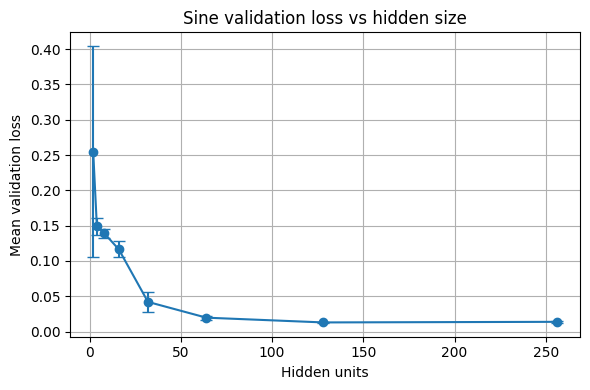

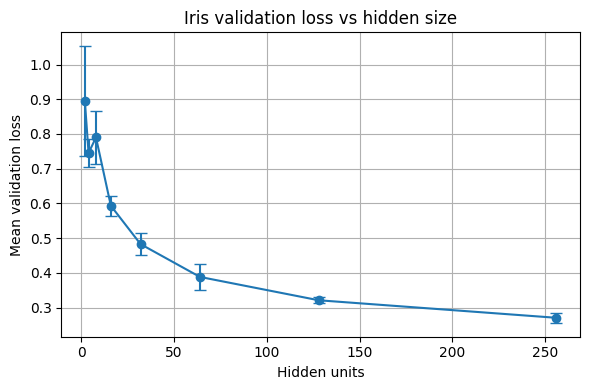

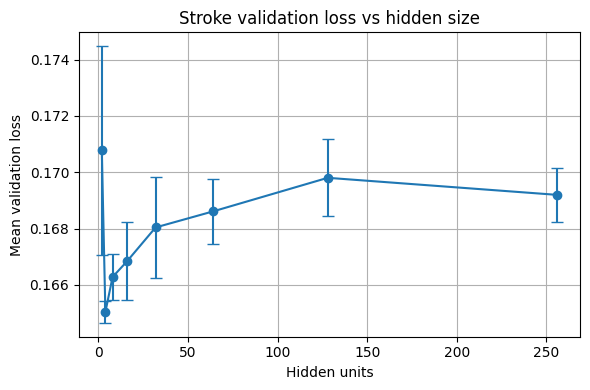

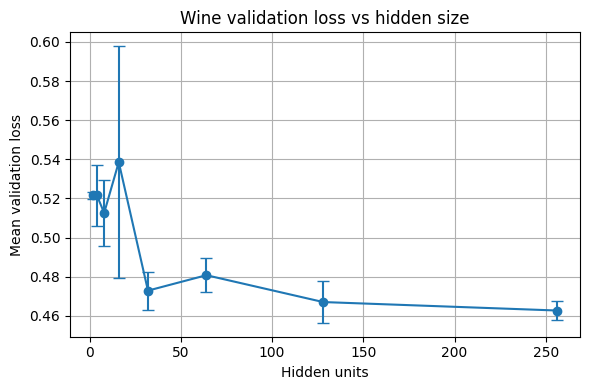

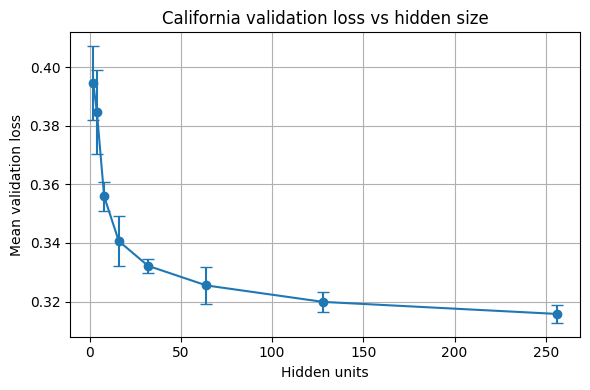

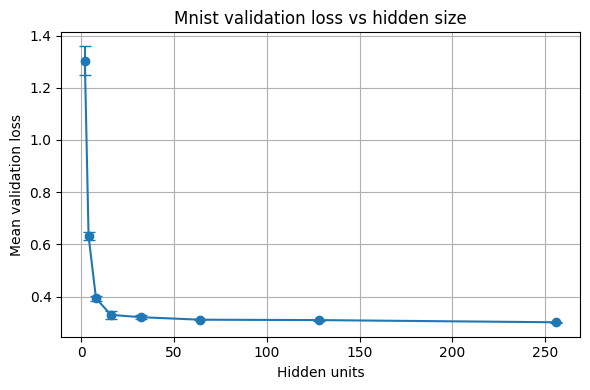

In [313]:
# Load results
with open("results/hidden_unit_search_results_20250930_134929.json", "r") as f:
    search_results = json.load(f)

datasets = list(search_results.keys())

for i, ds in enumerate(datasets):
    results = search_results[ds]["results"]
    hidden_sizes = [r["hidden_dim"] for r in results]
    mean_vals = [r["mean_val"] for r in results]
    std_vals = [r["std_val"] for r in results]
    plt.figure(figsize=(6, 4))
    plt.errorbar(hidden_sizes, mean_vals, yerr=std_vals, fmt='-o', capsize=4)
    plt.title(f"{ds.capitalize()} validation loss vs hidden size")
    plt.xlabel("Hidden units")
    plt.ylabel("Mean validation loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Parameter Tuning

In [368]:
def parameter_tuning(
    dataset_name,
    param_grid,
    hidden_dim,
    optimizer_name="sgd",  # "sgd", "scg", or "lfrog"
    classification=True,
    n_runs=3,
    epochs=50,
    batch_size=32
):
    X_train, y_train = datasets[dataset_name]["train"]
    X_val, y_val = datasets[dataset_name]["val"]
    output_dim = len(np.unique(y_train)) if classification else 1
    input_dim = X_train.shape[1]

    results = []

    # Select the training function
    if optimizer_name == "sgd":
        train_fn = train_sgd
    elif optimizer_name == "scg":
        train_fn = train_scg
    elif optimizer_name == "lfrog":
        train_fn = train_lfrog
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Use R seed list for reproducibility
    seeds = R[:n_runs] if 'R' in globals() else list(range(n_runs))


    for params in param_grid:
        val_losses = []
        accs, f1s, mses, r2s = [], [], [], []
        times = []

        for seed in seeds:
            np.random.seed(seed)
            torch.manual_seed(seed)

            model = FeedforwardNN(
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                output_dim=output_dim
            )

            if classification:
                y_train_run, y_val_run = y_train, y_val
            else:
                y_train_run = np.array(y_train).reshape(-1, 1).astype(np.float32)
                y_val_run = np.array(y_val).reshape(-1, 1).astype(np.float32)

            extra_kwargs = {k: v for k, v in params.items() if k != "hidden_dim"}

            start_time = time.time()
            if optimizer_name == "sgd":
                _, val_loss_curve = train_fn(
                    model,
                    X_train,
                    y_train_run,
                    X_val,
                    y_val_run,
                    epochs=epochs,
                    lr=extra_kwargs.get("lr", 0.01),
                    batch_size=batch_size,
                    classification=classification,
                    momentum=extra_kwargs.get("momentum", 0.0)
                )
            elif optimizer_name == "scg":
                # Convert data to torch tensors
                X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train_run, dtype=torch.long if classification else torch.float32)
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val_run, dtype=torch.long if classification else torch.float32)
                _, val_loss_curve = train_fn(
                    model,
                    X_train_tensor,
                    y_train_tensor,
                    X_val_tensor,
                    y_val_tensor,
                    max_epochs=epochs,
                    **extra_kwargs
                )
            elif optimizer_name == "lfrog":
                # Convert data to torch tensors
                X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train_run, dtype=torch.long if classification else torch.float32)
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val_run, dtype=torch.long if classification else torch.float32)
                # Choose loss_fn
                loss_fn = nn.CrossEntropyLoss() if classification else nn.MSELoss()
                _, val_loss_curve = train_fn(
                    model,
                    X_train_tensor,
                    y_train_tensor,
                    X_val_tensor,
                    y_val_tensor,
                    epochs=epochs,
                    loss_fn=loss_fn,
                    **extra_kwargs
                )
            else:
                raise ValueError(f"Unknown optimizer: {optimizer_name}")

            end_time = time.time()
            elapsed = end_time - start_time
            times.append(elapsed)
            val_losses.append(val_loss_curve[-1])

            # --- metrics ---
            model.eval()
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            with torch.no_grad():
                outputs = model(X_val_tensor)
                if classification:
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    accs.append(accuracy_score(y_val, preds))
                    f1s.append(f1_score(y_val, preds, average="weighted"))
                else:
                    preds = outputs.cpu().numpy().flatten()
                    # Check for NaNs before appending metrics
                    if (
                        np.isnan(y_val_run.flatten()).any()
                        or np.isnan(preds).any()
                    ):
                        print(f"Warning: NaNs detected in validation targets or predictions for {dataset_name} (seed={seed}). Skipping metrics for this run.")
                        print("y_val_run:", y_val_run.flatten())
                        print("preds:", preds)
                    else:
                        mses.append(mean_squared_error(y_val_run.flatten(), preds))
                        r2s.append(r2_score(y_val_run.flatten(), preds))

        results.append({
            "optimizer": optimizer_name,
            "params": params,
            "mean_val_loss": float(np.mean(val_losses)),
            "std_val_loss": float(np.std(val_losses)),
            "mean_acc": float(np.mean(accs)) if accs else None,
            "std_acc": float(np.std(accs)) if accs else None,
            "mean_f1": float(np.mean(f1s)) if f1s else None,
            "std_f1": float(np.std(f1s)) if f1s else None,
            "mean_mse": float(np.mean(mses)) if mses else None,
            "std_mse": float(np.std(mses)) if mses else None,
            "mean_r2": float(np.mean(r2s)) if r2s else None,
            "std_r2": float(np.std(r2s)) if r2s else None,
            "mean_time": float(np.mean(times)),
            "std_time": float(np.std(times)),
            "all_times": [float(t) for t in times]
        })

    return results


In [385]:
# best_hidden = {ds: search_results[ds]["selected"]["hidden_dim"] for ds in search_results}
best_hidden = {
    "sine": 32,
    "iris": 16,
    "stroke": 2,
    "wine": 8,
    "california": 64,
    "mnist": 64
}


param_grid_sgd = [
    {"lr": lr, "momentum": m}
    for lr, m in product(
        [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005],
        [0.0, 0.5, 0.9]
    )
]

param_grid_scg = [
    {"sigma": sigma, "lambda_init": lam}
    for sigma, lam in product(
        [1e-3, 5e-4, 1e-4, 5e-5, 1e-5],
        [1e-4, 1e-5, 1e-6, 1e-7]
    )
]

param_grid_lfrog = [
    {"dt": dt, "max_step": ms, "convergence_tol": tol}
    for dt, ms, tol in product(
        [0.5, 0.2, 0.1, 0.05, 0.01],
        [1.0, 0.5, 0.1],
        [1e-4, 1e-5, 1e-6]
    )
]

# --- Run tuning ---
all_results = {}

# # Iris (classification)
# all_results["iris"] = {
#     "sgd": parameter_tuning("iris", param_grid_sgd, hidden_dim=best_hidden["iris"], optimizer_name="sgd", classification=True),
#     "scg": parameter_tuning("iris", param_grid_scg, hidden_dim=best_hidden["iris"], optimizer_name="scg", classification=True),
#     "lfrog": parameter_tuning("iris", param_grid_lfrog, hidden_dim=best_hidden["iris"], optimizer_name="lfrog", classification=True)
# }

# Sine (regression)
all_results["sine"] = {
    "sgd": parameter_tuning("sine", param_grid_sgd, hidden_dim=best_hidden["sine"], optimizer_name="sgd", classification=False),
    "scg": parameter_tuning("sine", param_grid_scg, hidden_dim=best_hidden["sine"], optimizer_name="scg", classification=False),
    "lfrog": parameter_tuning("sine", param_grid_lfrog, hidden_dim=best_hidden["sine"], optimizer_name="lfrog", classification=False)
}

# Wine (regression)
all_results["wine"] = {
    "sgd": parameter_tuning("wine", param_grid_sgd, hidden_dim=best_hidden["wine"], optimizer_name="sgd", classification=False),
    "scg": parameter_tuning("wine", param_grid_scg, hidden_dim=best_hidden["wine"], optimizer_name="scg", classification=False),
    "lfrog": parameter_tuning("wine", param_grid_lfrog, hidden_dim=best_hidden["wine"], optimizer_name="lfrog", classification=False)
}

# Stroke (classification)
all_results["stroke"] = {
    "sgd": parameter_tuning("stroke", param_grid_sgd, hidden_dim=best_hidden["stroke"], optimizer_name="sgd", classification=True),
    "scg": parameter_tuning("stroke", param_grid_scg, hidden_dim=best_hidden["stroke"], optimizer_name="scg", classification=True),
    "lfrog": parameter_tuning("stroke", param_grid_lfrog, hidden_dim=best_hidden["stroke"], optimizer_name="lfrog", classification=True)
}

# --- Save results ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = f"results/param_tuning_results_{timestamp}.json"

with open(out_path, "w") as f:
    json.dump(all_results, f, indent=2)

print(f"All parameter tuning results saved to {out_path}")


Initial - Train 0.332554 Test 0.333872
Epoch    0 f=0.218495 test=0.198538 ||g||=9.67e-01 r=1.003 λ=5.00e-05 α=7.417e-02
Epoch   10 f=0.224030 test=0.199490 ||g||=8.00e-01 r=-0.557 λ=5.00e-05 α=5.061e-01
Epoch   20 f=0.224030 test=0.199490 ||g||=8.00e-01 r=-0.557 λ=5.12e-02 α=5.061e-01
Epoch   30 f=0.224030 test=0.199490 ||g||=8.00e-01 r=-0.557 λ=5.24e+01 α=5.061e-01
Epoch   40 f=0.224030 test=0.199490 ||g||=8.00e-01 r=-0.557 λ=5.37e+04 α=5.061e-01
Epoch   49 f=0.224030 test=0.199490 ||g||=8.00e-01 r=-0.557 λ=2.75e+07 α=5.061e-01
Final - Train 0.224030 Test 0.199490
Initial - Train 0.472124 Test 0.426829
Epoch    0 f=0.207522 test=0.206309 ||g||=8.27e-01 r=1.001 λ=5.00e-05 α=7.622e-02
Epoch   10 f=0.055242 test=0.049043 ||g||=8.30e-01 r=0.956 λ=9.77e-08 α=2.352e-02
Epoch   20 f=0.013100 test=0.014017 ||g||=2.46e-02 r=1.000 λ=9.54e-11 α=7.976e-02
Epoch   30 f=0.012818 test=0.013702 ||g||=2.94e-02 r=-0.196 λ=1.53e-09 α=1.000e+00
Epoch   40 f=0.012818 test=0.013702 ||g||=2.94e-02 r=-0.196

In [386]:
def select_best_one_se(results, minimization=True):
    """
    Apply the one-standard-error rule to a list of results for one dataset × optimizer.

    Args:
        results: list of dicts, each containing "mean_val_loss" and "std_val_loss"
        minimization: True if smaller metric is better (e.g., loss, MSE),
                      False if larger metric is better (e.g., accuracy, F1, R2).

    Returns:
        dict with:
          - best_config: the config with smallest mean_val_loss (or largest if maximization)
          - selected_config: the parsimonious config chosen via one-SE rule
          - threshold: cutoff value
          - candidates: all configs within threshold
    """
    if minimization:
        # 1. Find best (lowest mean)
        best = min(results, key=lambda x: x["mean_val_loss"])
        se_best = best["std_val_loss"]  # already averaged per seed → std across runs
        threshold = best["mean_val_loss"] + se_best

        # 2. All configs within one-SE
        candidates = [r for r in results if r["mean_val_loss"] <= threshold]

        # 3. Parsimony: choose simplest candidate (here = lowest learning rate if SGD, lowest dt if LFROG)
        # Fallback: pick the one with lowest mean_time if multiple remain
        selected = min(candidates, key=lambda x: (x["params"].get("lr", x["mean_time"])))
    else:
        # Same logic but for maximization
        best = max(results, key=lambda x: x["mean_val_loss"])
        se_best = best["std_val_loss"]
        threshold = best["mean_val_loss"] - se_best
        candidates = [r for r in results if r["mean_val_loss"] >= threshold]
        selected = min(candidates, key=lambda x: (x["params"].get("lr", x["mean_time"])))

    return {
        "best_config": best,
        "selected_config": selected,
        "threshold": threshold,
        "candidates": candidates
    }


In [387]:
def _parsimony_key(result):
    p = result["params"]
    if "lr" in p:
        return (p["lr"], result["mean_time"])
    if "dt" in p:
        return (p["dt"], result["mean_time"])
    if "sigma" in p:
        return (p["sigma"], result["mean_time"])
    return (result["mean_time"],)

def select_best_one_se_generic(results, n_runs, minimization=True):
    if minimization:
        best = min(results, key=lambda x: x["mean_val_loss"])
        se_best = best["std_val_loss"] / np.sqrt(n_runs)
        threshold = best["mean_val_loss"] + se_best
        candidates = [r for r in results if r["mean_val_loss"] <= threshold]
    else:
        best = max(results, key=lambda x: x["mean_val_loss"])
        se_best = best["std_val_loss"] / np.sqrt(n_runs)
        threshold = best["mean_val_loss"] - se_best
        candidates = [r for r in results if r["mean_val_loss"] >= threshold]
    selected = min(candidates, key=_parsimony_key)
    return {"best_config": best,
            "selected_config": selected,
            "threshold": threshold,
            "candidates": candidates,
            "se_best": se_best}

def build_selection_summary(all_results, n_runs, minimization=True):
    rows = []
    for dataset, optim_dict in all_results.items():
        for optimizer, results in optim_dict.items():
            if not results:
                continue
            sel = select_best_one_se_generic(results, n_runs=n_runs, minimization=minimization)
            best = sel["best_config"]; chosen = sel["selected_config"]
            rows.append({
                "dataset": dataset,
                "optimizer": optimizer,
                "best_params": json.dumps(best["params"], sort_keys=True),
                "best_mean_val_loss": best["mean_val_loss"],
                "best_std_val_loss": best["std_val_loss"],
                "best_mean_time": best.get("mean_time"),
                "best_std_time": best.get("std_time"),
                "selected_params": json.dumps(chosen["params"], sort_keys=True),
                "selected_mean_val_loss": chosen["mean_val_loss"],
                "selected_std_val_loss": chosen["std_val_loss"],
                "selected_mean_time": chosen.get("mean_time"),
                "selected_std_time": chosen.get("std_time"),
                "time_ratio_selected_over_best": (
                    (chosen.get("mean_time") / best.get("mean_time"))
                    if best.get("mean_time") and chosen.get("mean_time") else None
                ),
                "threshold": sel["threshold"],
                "se_best": sel["se_best"],
                "n_candidates": len(sel["candidates"])
            })
    return pd.DataFrame(rows).sort_values(["dataset","optimizer"]).reset_index(drop=True)


In [389]:
# Load results
with open("results/param_tuning_results_20251001_185306.json", "r") as f:
    all_results = json.load(f)

# Example: sine → SGD results
sine_sgd_results = all_results["sine"]["sgd"]

selection = select_best_one_se(sine_sgd_results, minimization=True)

# Ensure results JSON loaded (reuse all_results if already in scope)
# If not loaded yet, uncomment:
# with open("results/param_tuning_results_20251001_173314.json", "r") as f:
#     all_results = json.load(f)

summary_df = build_selection_summary(all_results, n_runs=3, minimization=True)
print(summary_df)

# Save
os.makedirs("results", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"results/param_tuning_selection_summary_{timestamp}.csv"
json_path = f"results/param_tuning_selection_summary_{timestamp}.json"
summary_df.to_csv(csv_path, index=False)
summary_df.to_json(json_path, orient="records", indent=2)
print(f"Saved summary to:\n  {csv_path}\n  {json_path}")


  dataset optimizer                                        best_params  \
0    sine     lfrog  {"convergence_tol": 0.0001, "dt": 0.5, "max_st...   
1    sine       scg            {"lambda_init": 1e-05, "sigma": 0.0005}   
2    sine       sgd                       {"lr": 0.1, "momentum": 0.5}   
3  stroke     lfrog  {"convergence_tol": 0.0001, "dt": 0.5, "max_st...   
4  stroke       scg            {"lambda_init": 0.0001, "sigma": 1e-05}   
5  stroke       sgd                      {"lr": 0.01, "momentum": 0.9}   
6    wine     lfrog  {"convergence_tol": 0.0001, "dt": 0.5, "max_st...   
7    wine       scg             {"lambda_init": 1e-07, "sigma": 5e-05}   
8    wine       sgd                      {"lr": 0.01, "momentum": 0.5}   

   best_mean_val_loss  best_std_val_loss  best_mean_time  best_std_time  \
0            0.014306           0.000499        0.008822       0.000257   
1            0.011611           0.000162        0.015140       0.000720   
2            0.012094           0.

In [391]:
def aggregate_global_best(all_results, optimizers=("sgd","scg","lfrog"), require_full_coverage=False):
    """
    Choose one global hyperparameter set per optimizer across datasets.
    Ranks by mean_relative_gap, worst_relative_gap, avg_rank, mean_time_avg.
    """
    per_optimizer = {}
    for opt in optimizers:
        # Collect runs per dataset for this optimizer
        per_dataset = {
            ds: opt_dict[opt]
            for ds, opt_dict in all_results.items()
            if opt in opt_dict and opt_dict[opt]
        }
        if not per_dataset:
            continue

        # Best loss per dataset (scale-free normalization)
        best_loss = {
            ds: min(r["mean_val_loss"] for r in runs)
            for ds, runs in per_dataset.items()
        }

        metrics = defaultdict(lambda: {"losses":{}, "rel":{}, "ranks":{}, "times":{}})

        # Accumulate stats
        for ds, runs in per_dataset.items():
            sorted_runs = sorted(runs, key=lambda r: r["mean_val_loss"])
            for rank, r in enumerate(sorted_runs, start=1):
                k = tuple(sorted(r["params"].items()))
                loss = r["mean_val_loss"]
                rel_gap = (loss - best_loss[ds]) / (best_loss[ds] + 1e-12)
                m = metrics[k]
                m["losses"][ds] = loss
                m["rel"][ds] = rel_gap
                m["ranks"][ds] = rank
                m["times"][ds] = r.get("mean_time", math.nan)

        rows = []
        full_cov = len(per_dataset)
        for k, d in metrics.items():
            cov = len(d["losses"])
            if require_full_coverage and cov < full_cov:
                continue
            rels = list(d["rel"].values())
            ranks = list(d["ranks"].values())
            times = list(d["times"].values())
            rows.append({
                "optimizer": opt,
                "params": dict(k),
                "datasets_covered": cov,
                "mean_relative_gap": float(np.mean(rels)),
                "worst_relative_gap": float(np.max(rels)),
                "avg_rank": float(np.mean(ranks)),
                "mean_time_avg": float(np.nanmean(times)),
            })

        if not rows:
            continue

        df = pd.DataFrame(rows).sort_values(
            ["mean_relative_gap","worst_relative_gap","avg_rank","mean_time_avg"]
        ).reset_index(drop=True)

        per_optimizer[opt] = {
            "candidates": df.to_dict(orient="records"),
            "selected": df.iloc[0].to_dict()
        }

    return per_optimizer

global_hparam_choices = aggregate_global_best(all_results, require_full_coverage=False)

print("Global hyperparameter choices:")
for opt, info in global_hparam_choices.items():
    sel = info["selected"]
    print(f"{opt}: {sel['params']} "
          f"mean_rel_gap={sel['mean_relative_gap']:.3e} "
          f"worst_rel_gap={sel['worst_relative_gap']:.3e} "
          f"avg_rank={sel['avg_rank']:.2f}")

os.makedirs("results", exist_ok=True)
with open("results/global_hparam_choices.json","w") as f:
    json.dump(global_hparam_choices, f, indent=2)

# Optional: flat CSV of selected
selected_rows = [
    {
        "optimizer": opt,
        **info["selected"]["params"],
        **{k: v for k, v in info["selected"].items() if k not in ("params","optimizer")}
    }
    for opt, info in global_hparam_choices.items()
]
pd.DataFrame(selected_rows).to_csv("results/global_hparam_choices_selected.csv", index=False)

Global hyperparameter choices:
sgd: {'lr': 0.01, 'momentum': 0.9} mean_rel_gap=2.813e-03 worst_rel_gap=6.152e-03 avg_rank=2.00
scg: {'lambda_init': 1e-07, 'sigma': 0.0005} mean_rel_gap=6.861e-03 worst_rel_gap=2.058e-02 avg_rank=7.33
lfrog: {'convergence_tol': 0.0001, 'dt': 0.2, 'max_step': 0.5} mean_rel_gap=1.482e-01 worst_rel_gap=3.894e-01 avg_rank=6.00


### Final Experiments

In [ ]:
# Iris x SGD


### Visualisation and Results